<a href="https://colab.research.google.com/github/KataGMSP/magistracy-veriga/blob/main/%D0%97%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_%D0%BF%D0%BE_%D0%BF%D1%80%D0%BE%D0%B3%D1%80%D0%B0%D0%BC%D0%BC%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D1%8E_%D0%A0%D0%B0%D0%BD%D0%B6%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_web_%D1%81%D1%82%D1%80%D0%B0%D0%BD%D0%B8%D1%86.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PageRank
В этом блокноте вы расширите свои знания о собственных векторах и собственных значениях, изучая алгоритм PageRank. Блокнот состоит из двух частей: первая представляет собой рабочий лист, который поможет вам быстрее понять, как работает алгоритм - здесь мы рассмотрим микроинтернет с менее чем 10 веб-сайтами и посмотрим, что он делает и что может пойти не так. Второй - это оценка, которая проверяет ваше применение собственной теории к этой проблеме путем написания кода и вычисления рейтинга страницы в большой сети, представляющей подсекцию Интернета.

## Part 1 - Worksheet
### Introduction

PageRank (разработанный Ларри Пейджем и Сергеем Брином) произвел революцию в веб-поиске, создав ранжированный список веб-страниц на основе базовых возможностей подключения к сети. 

Алгоритм PageRank основан на идеальном случайном веб-серфере, который при переходе на страницу переходит на следующую страницу, щелкая ссылку. Пользователь имеет равную вероятность щелкнуть любую ссылку на странице и, достигнув страницы без ссылок, имеет равную вероятность перехода на любую другую страницу, введя ее URL. Кроме того, пользователь может иногда выбирать случайный URL вместо перехода по ссылкам на странице. PageRank - это ранжированный порядок страниц от наиболее к наименее вероятной странице, которую будет просматривать пользователь.


In [1]:
!wget https://github.com/andrew-veriga/MathForML/raw/master/MathForMLAssignes.zip
!unzip -u MathForMLAssignes.zip
!rm MathForMLAssignes.zip

--2021-11-15 12:45:12--  https://github.com/andrew-veriga/MathForML/raw/master/MathForMLAssignes.zip
Resolving github.com (github.com)... 13.114.40.48
Connecting to github.com (github.com)|13.114.40.48|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/andrew-veriga/MathForML/master/MathForMLAssignes.zip [following]
--2021-11-15 12:45:13--  https://raw.githubusercontent.com/andrew-veriga/MathForML/master/MathForMLAssignes.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2369 (2.3K) [application/zip]
Saving to: ‘MathForMLAssignes.zip’

MathForMLAssignes.z 100%[===================>]   2.31K  --.-KB/s    in 0s      

2021-11-15 12:45:13 (34.5 MB/s) - ‘MathForMLAssignes.zip’ saved [2369/2369]

Arch

In [2]:
# Before we begin, let's load the libraries.
%pylab notebook
import numpy as np
import numpy.linalg as la
from PageRankFunctions import *
np.set_printoptions(suppress=True)

Populating the interactive namespace from numpy and matplotlib


### PageRank как задача линейной алгебры
Представьте себе микроинтернет в котором есть только 6 вебсайтов (**A**vocado, **B**ullseye, **C**atBabel, **D**romeda, **e**Tings, and **F**aceSpace).
Каждый веб-сайт ссылается на некоторые другие, и все они образуют сеть, как показано на рисунке.

![A Micro-Internet](https://github.com/andrew-veriga/MathForML/raw/master/internet.png "A Micro-Internet")

Принцип построения PageRank заключается в том, что важные веб-сайты будут ссылаться на важные веб-сайты.
Этот несколько рекурсивный принцип ляжет в основу нашей идеи.

Представьте себе 100 *Прокрастинирующих Патов* в нашем микро-Интернете, каждый просматривает один веб-сайт в один момент времени.

Каждую минуту Паты переходят на своем сайте по ссылке на другой сайт в микроинтернет.

Через некоторое время веб-сайты, на которые больше всего ссылаются, будут посещать больше Патов, и в конечном итоге на каждой минуте вместо одного Пата, покидающего веб-сайт, будет входить другой, сохраняя общее количество Патов на каждом веб-сайте постоянным.
PageRank - это просто рейтинг веб-сайтов по тому, сколько на них отметок в конце этого процесса.

Мы представляем количество Патов на каждом веб-сайте вектором,
$$\mathbf{r} = \begin{bmatrix} r_A \\ r_B \\ r_C \\ r_D \\ r_E \\ r_F \end{bmatrix}$$
И пусть количество Патов на каждом веб-сайте в минуту $ i + 1 $ выводится из количества Патов в минуту $ i $ посредством преобразования матрицы.


$$ \mathbf{r}^{(i+1)} = L \,\mathbf{r}^{(i)}$$
с матрицей $L$, имеющей вид,
$$ L = \begin{bmatrix}
L_{A→A} & L_{B→A} & L_{C→A} & L_{D→A} & L_{E→A} & L_{F→A} \\
L_{A→B} & L_{B→B} & L_{C→B} & L_{D→B} & L_{E→B} & L_{F→B} \\
L_{A→C} & L_{B→C} & L_{C→C} & L_{D→C} & L_{E→C} & L_{F→C} \\
L_{A→D} & L_{B→D} & L_{C→D} & L_{D→D} & L_{E→D} & L_{F→D} \\
L_{A→E} & L_{B→E} & L_{C→E} & L_{D→E} & L_{E→E} & L_{F→E} \\
L_{A→F} & L_{B→F} & L_{C→F} & L_{D→F} & L_{E→F} & L_{F→F} \\
\end{bmatrix}
$$
где столбцы представляют вероятность *ухода* с веб-сайта на любой другой веб-сайта, а сумма равна единице.
Строки определяют, вероятность *входа* на веб-сайт с любого другого, и их сумма не должна равняться единице.
Долгое время поведение этой системы - это когда $ \mathbf{r}^{(i+1)} = \mathbf{r}^{(i)}$, поэтому мы опустим здесь верхние индексы, и это позволяет нам писать,
$$ L \,\mathbf{r} = \mathbf{r}$$
 
которое является уравнением на собственные значения для матрицы $L$ с собственным значением 1 (это гарантируется вероятностной структурой матрицы $L$)

Заполните матрицу $ L $ ниже, в которой не указан столбец для веб-сайта *FaceSpace* (**F**).

Помните, что это вероятность ухода с соотвествующего столбцу веб-сайта на другой, поэтому каждый столбец в сумме должен равняться единице (путем масштабирования по количеству ссылок).

In [3]:
# RЗаменить ??? здесь с вероятностью перехода по ссылке на каждый веб-сайт при выходе с веб-сайта F (FaceSpace).
L = np.array([[0,   1/2, 1/3, 0, 0,   0 ],
              [1/3, 0,   0,   0, 1/2, 0 ],
              [1/3, 1/2, 0,   1, 0,   1/2 ],
              [1/3, 0,   1/3, 0, 1/2, 1/2 ],
              [0,   0,   0,   0, 0,   0 ],
              [0,   0,   1/3, 0, 0,   0 ]])

В принципе, мы могли бы использовать библиотеку линейной алгебры, как показано ниже, для вычисления собственных значений и векторов.

И это сработает для небольшой системы. Но для больших систем это становится неуправляемым.

А поскольку нас интересует только главный собственный вектор (тот, который имеет наибольшее собственное значение, которое в данном случае будет равно 1), мы можем использовать метод *степенной итерации*, который будет лучше масштабироваться, и он быстрее для больших систем.

Используйте приведенный ниже код, чтобы узнать рейтинг страницы для этого микроинтернета.

In [4]:
eVals, eVecs = la.eig(L) # Возвращает собственные вектор и значение
order = np.absolute(eVals).argsort()[::-1] # Сортирует их по собственным значениям
eVals = eVals[order]
eVecs = eVecs[:,order]

r = eVecs[:, 0] # Присваивает r главный собственный вектор
100 * np.real(r / np.sum(r)) # приводит сумму собственных векторов к единице и умножает на количество прокрастинирующих Патов

array([16.        ,  5.33333333, 40.        , 25.33333333,  0.        ,
       13.33333333])

Из этого списка мы можем увидеть количество откладываний на потом, которые мы ожидаем найти на каждом веб-сайте спустя долгое время.
отсортированный по убыванию * популярности * (на основе этого показателя), рейтинг PageRank этого микроинтернета составляет:

**C**atBabel, **D**romeda, **A**vocado, **F**aceSpace, **B**ullseye, **e**Tings
 
Смотря на схему микро-интернета, вы этого ожидали?
Убедитесь, что это разумный рейтинг: страницы выглядят важными, судя по количеству ссылок на них.

Давайте теперь попробуем получить тот же результат, используя метод Power-Iteration, который был рассмотрен в лекции.
Этот метод будет намного лучше при работе с большими системами.

Сначала давайте настроим наш начальный вектор, $\mathbf{r}^{(0)}$, 
так, чтобы у нас были 100 прокрастинирующих Патов, равномерно распределенных по всем нашим 6 веб-сайтам.

In [5]:
r = 100 * np.ones(6) / 6 # Устанавливает этот вектор (6 записей размером 1/6 × 100 каждая)
r # Показывает его значение

array([16.66666667, 16.66666667, 16.66666667, 16.66666667, 16.66666667,
       16.66666667])

Затем давайте обновим вектор до следующей минуты с помощью матрицы $L$.
Выполняйте следующую ячейку несколько раз, пока ответ не стабилизируется.

In [15]:
r = L @ r # Применить преобразование L к r
r # Показать его значение
# Повторно запустите эту ячейку несколько раз, чтобы получить правильный ответ.

array([16.043354  ,  5.34020651, 39.82558888, 25.38634051,  0.        ,
       13.4045101 ])

Мы можем автоматизировать применение этой матрицы несколько раз следующим образом:

In [16]:
r = 100 * np.ones(6) / 6 # обновить этот вектор единицами (6 записей со значениями = 1/6 × 100 каждая)
for i in np.arange(100) : # повторить 100 раз
    r = L @ r
r

array([16.        ,  5.33333333, 40.        , 25.33333333,  0.        ,
       13.33333333])

Или, что правильнее, мы можем продолжать цикл, пока не достигнем требуемой точности.

In [17]:
r = 100 * np.ones(6) / 6 # обновить этот вектор единицами (6 записей со значениями = 1/6 × 100 каждая)
lastR = r
r = L @ r
i = 0
while la.norm(lastR - r) > 0.01 :
    lastR = r
    r = L @ r
    i += 1
print(str(i) + " iterations to convergence.")
r

18 iterations to convergence.


array([16.00149917,  5.33252025, 39.99916911, 25.3324738 ,  0.        ,
       13.33433767])

Посмотрите, порядок PageRank устанавливается довольно быстро, и вектор сходится к значению, которое мы вычислили ранее, после нескольких десятков повторов.

Поздравляю! Вы только что рассчитали свой первый PageRank!

### Параметр демпфирования

Система, которую мы только что изучили, довольно быстро пришла к правильному ответу. Давайте рассмотрим расширение нашего микро-интернета, в котором что-то начинает идти не так.

Допустим, в микроинтернет добавлен новый веб-сайт: **G**eoff.
Этот веб-сайт связан с **F**aceSpace  и ссылается только на себя.

![Расширенный микро-интернет](https://github.com/andrew-veriga/MathForML/raw/master/internet2.png "An Expanded Micro-Internet")

Интуитивно понятно, что только *FaceSpace*, который находится в нижней половине рейтинга страницы, ссылается на этот веб-сайт среди двух других, на которые он ссылается,
поэтому мы можем ожидать, что у сайта *Geoff* будет соответственно низкий рейтинг PageRank.

Создайте новую матрицу $L$ для расширенного микро-интернета и используйте Power-Iteration для вектора Прокрастинирующий Пат.
Посмотрим, что произойдет…

In [18]:
# Мы назовем её L2, чтобы отличать от предыдущей L
L2 = np.array([[0,   1/2, 1/3, 0, 0,   0,   0 ],
               [1/3, 0,   0,   0, 1/2, 1/3, 0 ],
               [1/3, 1/2, 0,   1, 0,   1/3, 0 ],
               [1/3, 0,   1/3, 0, 1/2, 0,   0 ],
               [0,   0,   0,   0, 0,   0,   0 ],
               [0,   0,   1/3, 0, 0,   0,   0 ],
               [0,   0,   0,   0, 0,   1/3, 1 ]])

In [19]:
r = 100 * np.ones(7) / 7 # задать начальный единичный вектор (7 записей со значениями = 1/7 × 100 каждая)
lastR = r
r = L2 @ r
i = 0
while la.norm(lastR - r) > 0.01 :
    lastR = r
    r = L2 @ r
    i += 1
print(str(i) + " итераций до схождения.")
r

136 итераций до схождения.


array([ 0.03715539,  0.02190538,  0.07376446,  0.0386529 ,  0.        ,
        0.02570514, 99.80281672])

Что-то тут не очень. Похоже, что *Джефф* забирает весь трафик в микро-интернете и каким-то образом занимает верхние позиции в рейтинге страниц.
Такое поведение можно понять, потому что как только Пэт попадает на сайт *Джеффа*, он не может покинуть его, так как все ссылки ведут обратно на Джеффа.

Чтобы бороться с этим, мы можем добавить небольшую вероятность того, что прокрастинирующие Паты не переходят по какой-либо ссылке на веб-странице, а вместо этого посещают веб-сайт в микроинтернете случайным образом.
Пусть вероятность того, что они перейдут по ссылке, составляет $d$, и поэтому вероятность выбора случайного веб-сайта составляет $1-d$.
Мы можем использовать новую матрицу, чтобы выяснить, куда каждую минуту заходит Пэт.
$$ M = d \, L + \frac{1-d}{n} \, J $$
где $J$ - матрица $n\times n$, где каждый элемент равен единице.

Если $ d $ равен единице, у нас тот же случай, что был и раньше, но если $ d $ равен нулю, мы всегда будем посещать случайную веб-страницу, и, следовательно, все веб-страницы будут иметь одинаковую вероятность и равный рейтинг.
Чтобы это расширение работало лучше всего, $ 1-d $ должно быть довольно маленьким - хотя мы не будем вдаваться в обсуждение того, насколько он маленький.

Давайте повторим этот PageRank с этим расширением.

In [22]:
d = 0.8 # можете поиграть с этим параметром после однократного запуска кода.
M = d * L2 + (1-d)/7 * np.ones([7, 7]) # np.ones() - матрица J , состоящая из единиц.

In [23]:
r = 100 * np.ones(7) / 7 # вектор из 7 одинаковых значений, каждое равно 1/7 × 100
lastR = r
r = M @ r
i = 0
while la.norm(lastR - r) > 0.01 :
    lastR = r
    r = M @ r
    i += 1
print(str(i) + " итераций до схождения.")
r

22 итераций до схождения.


array([13.2718056 , 10.01105956, 24.03385741, 13.94943272,  2.85714286,
        9.26700824, 26.60969361])

Так, безусловно, лучше: PageRank дает разумные числа для прокрастинирующих Патов, которые появляются на каждой веб-странице.
Однако этот метод по-прежнему предсказывает, что у Джеффа высокий рейтинг веб-страницы.
Это можно рассматривать как следствие использования маленькой сети. Мы также могли бы обойти проблему, не подсчитывая ссылки на себя при создании L-матрицы (если у веб-сайта нет исходящих ссылок, сделайте его ссылающимся на все сайты одинаково).
Мы не будем углубляться в этот метод, поскольку это уже сфера улучшения PageRank, а не задач собственных векторов и собственных значений.

Теперь, когда вы получили представление о PageRank, вы можете создать свой собственный код для расчета PageRank веб-сайта с тысячами записей.

Удачи!

## Часть 2 - Задание
В этом задании от вас требуется создать функцию, которая может вычислить PageRank для произвольно большой матрицы вероятностей.
Это последнее задание курса даст меньше рекомендаций, чем предыдущие.
Ожидается, что вы будете использовать код из предыдущего примера и приспособите его под свои нужды.



In [57]:
# GRADED FUNCTION
# Complete this function to provide the PageRank for an arbitrarily sized internet.
# I.e. the principal eigenvector of the damped system, using the power iteration method.
# (Normalisation doesn't matter here)
# The functions inputs are the linkMatrix, and d the damping parameter - as defined in this worksheet.
def pageRank(linkMatrix, d) :
    n = linkMatrix.shape[0]
    M = d * linkMatrix + (1-d)/n * np.ones([n,n])
    r = 100 * np.ones(n) / n
    lastR = r
    r = M @ r
    i = 0
    
    while la.norm(lastR - r) > 0.01 :
      lastR = r
      r = M @ r
      i = +1

    print(str(i) + " итераций до схождения.\n")
    
    return r


## Протестируйте свой код перед отправкой
Чтобы проверить код, который вы написали выше, запустите ячейку (выберите ячейку выше, затем нажмите кнопку воспроизведения [▶ |] или нажмите Shift-Enter).
Затем вы можете использовать приведенный ниже код, чтобы проверить свою функцию.
вы можете редактировать и запускать его сколько угодно.

In [58]:
# Use the following function to generate internets of different sizes.
generate_internet(5)

array([[0. , 0. , 0. , 0. , 0.2],
       [1. , 1. , 0. , 0. , 0.2],
       [0. , 0. , 1. , 0. , 0.2],
       [0. , 0. , 0. , 1. , 0.2],
       [0. , 0. , 0. , 0. , 0.2]])

In [59]:
# Test your PageRank method against the built in "eig" method.
# You should see yours is a lot faster for large internets

# Сравните свой метод PageRank со встроенным методом 'eig'.
# Вы должны увидеть, что ваш сайт работает намного быстрее для больших сетей
L = generate_internet(10)

In [60]:
pageRank(L, 1)

1 итераций до схождения.



array([ 0.01833556,  0.00902511,  0.00902511,  0.01833556,  0.05349   ,
        0.09906634,  0.00902511,  0.03457473,  0.03457473, 99.71454776])

In [61]:

# Обратите внимание, это вычисление собственных значений матрицы ссылок, L,
# без демпфирования. Это может дать другие результаты, чем функция pageRank.
# Если хотите, вы можете изменить эту ячейку, чтобы включить демпфирование.

eVals, eVecs = la.eig(L) # выдает собственные векторы и значения
order = np.absolute(eVals).argsort()[::-1] # сортировка по собственным значениям
eVals = eVals[order]
eVecs = eVecs[:,order]

r = eVecs[:, 0]
100 * np.real(r / np.sum(r))

array([ 0.0000002 ,  0.0000001 ,  0.0000001 ,  0.0000002 ,  0.00000055,
        0.000001  ,  0.0000001 ,  0.00000035,  0.00000035, 99.99999705])

1 итераций до схождения.



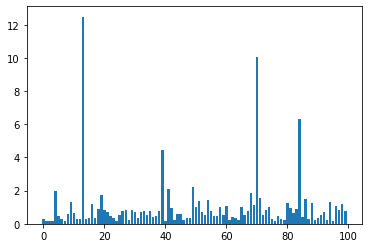

In [62]:
# Вы можете просмотреть PageRank графически.
# Этот код будет рисовать столбчатую диаграмму, для каждого веб-сайта в сгенерированном Интернете,
# Высота каждого столбца будет рейтингом в PageRank.
# запустите этот код, чтобы увидеть PageRank для каждого варианта интернета, который вы создали.
# Надеюсь, вы увидите, что вы могли бы ожидать:
# есть несколько кластеров полезных веб-сайтов, но большинство в Интернете - мусор
%matplotlib inline
r = pageRank(generate_internet(100), 0.9)
plt.bar(arange(r.shape[0]), r);